Здесь попробуем оценить точность используя новый метод с учётом видимых угловых размеров объекта в штрафе используя для в оригинале разметку open street map и сравнивая её с предсказанной разметкой для агента.

In [1]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs, draw_all_rectangles
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams
from circle_diagram import calculate_penalty_for_diagrams

from utils import read_pickle, dump_pickle


In [3]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')
points_to_centers_3_4 = read_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle')

In [10]:
predictions_folder = '../dataset/predictions/'
predicts_osm_folder = 'predicts_osm'
rectangled_predicts_folder = 'rectangled_predicts_pixel'
objects_predicts_folder = 'rectangled_predicts_obj'

osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

orig_osm_objects_path = '../dataset/osm_objects/'

In [5]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

In [6]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print("Sectors count:", sectors_count)

Sectors count: 616


In [7]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
#         penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [8]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [9]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [11]:
def calculate_precision_k_for_one(img_id, max_k):
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=True)
    
    img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
    img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    
    is_in_k_one_image = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent, with_angle_penalty=True)
#         agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])

        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [12]:
%%time
is_in_k_one_image = calculate_precision_k_for_one(test_ids[0], max_k=47)

CPU times: user 4.04 s, sys: 5.36 ms, total: 4.05 s
Wall time: 4.04 s


In [13]:
np.array(is_in_k_one_image)[:, 0].sum() / len(is_in_k_one_image)

0.08

In [14]:
np.array(is_in_k_one_image)[:, 1].sum() / len(is_in_k_one_image)

0.12

Даже тут точность получилась выше, чем просто случайность.

In [15]:
%%time
is_in_k = []

for img_id in test_ids[:100]:
    
    is_in_k += calculate_precision_k_for_one(img_id, max_k=48)
    
    if len(is_in_k) % 200 == 0:
        print(len(is_in_k))
        

200
400


../utils.py:39: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
CPU times: user 5min 7s, sys: 403 ms, total: 5min 7s
Wall time: 5min 8s


In [16]:
is_in_k = np.array(is_in_k)

acc_k = []
for i in range(48):
    acc_k.append(is_in_k[:, i].sum() / is_in_k.shape[0])

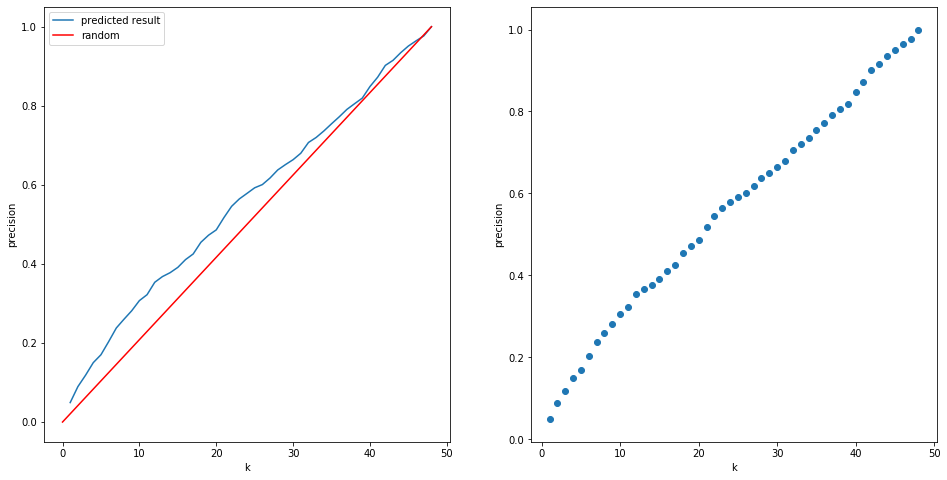

In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.plot(range(1, 49), acc_k, label='predicted result')
plt.plot(range(49), [i / 48 for i in range(49)], color='red', label='random')
plt.xlabel('k')
plt.ylabel('precision')
plt.legend()

plt.subplot(122)
plt.scatter(range(1, 49), acc_k)
plt.xlabel('k')
plt.ylabel('precision')

plt.show()

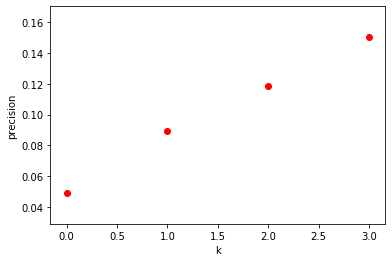

In [18]:
plt.scatter(range(4), acc_k[:4], color='red')
plt.xlabel('k')
plt.ylabel('precision')

plt.show()

In [19]:
for k in range(48):
    print(f"K: {k+1}, precision - {acc_k[k]}")

K: 1, precision - 0.0492
K: 2, precision - 0.0896
K: 3, precision - 0.1185
K: 4, precision - 0.1502
K: 5, precision - 0.1702
K: 6, precision - 0.2033
K: 7, precision - 0.2379
K: 8, precision - 0.2601
K: 9, precision - 0.2814
K: 10, precision - 0.3071
K: 11, precision - 0.3221
K: 12, precision - 0.3535
K: 13, precision - 0.3679
K: 14, precision - 0.3778
K: 15, precision - 0.3912
K: 16, precision - 0.4108
K: 17, precision - 0.4251
K: 18, precision - 0.4546
K: 19, precision - 0.4726
K: 20, precision - 0.486
K: 21, precision - 0.5171
K: 22, precision - 0.5456
K: 23, precision - 0.5643
K: 24, precision - 0.5783
K: 25, precision - 0.5925
K: 26, precision - 0.6006
K: 27, precision - 0.6173
K: 28, precision - 0.6376
K: 29, precision - 0.6511
K: 30, precision - 0.6636
K: 31, precision - 0.6799
K: 32, precision - 0.7071
K: 33, precision - 0.7198
K: 34, precision - 0.7362
K: 35, precision - 0.7544
K: 36, precision - 0.772
K: 37, precision - 0.7908
K: 38, precision - 0.8052
K: 39, precision - 0.81